In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

import numpy as np
from matplotlib import pyplot as plt

from models import CNN1D_1l_RNN, HiPPO, HiPPOMem
from model.model import Model
from train import train_lambda, eval_lambda
import hippo

In [2]:
print(dir(hippo))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'legs_euler_backward', 'legs_euler_forward', 'legs_function_approx_trapezoidal', 'legs_trapezoidal', 'legt_euler_forward']


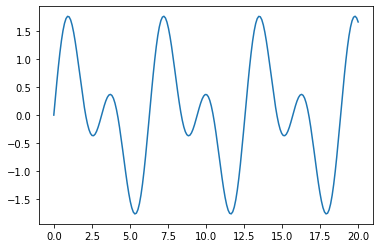

In [3]:
signal = lambda t: np.sin(t) + np.sin(2*t)# + np.random.normal(loc=0.0, scale=0.2, size=t.shape)# + t# + np.random.normal(loc=0.0, scale=0.3, size=t.shape)
ticks = np.linspace(0, 20, 200)
plt.plot(ticks, signal(ticks))

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device = torch.device("cpu")
torch.manual_seed(1)
f = 128
bs=128
tr = 48
lr=0.001
e=1000

  0%|          | 0/1000 [00:00<?, ?it/s]

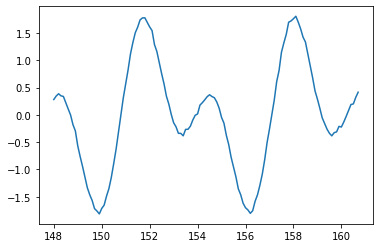

In [5]:
lstm = CNN1D_1l_RNN(16, int(tr/0.1), stacked=3, future = f, cell_type="LSTM")
train_lambda(lstm, signal, future = f, time_range=tr, epochs = e, batch_size=bs, lr=lr, dev = device)

  0%|          | 0/1000 [00:00<?, ?it/s]

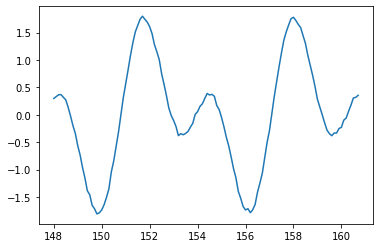

In [9]:
gru = CNN1D_1l_RNN(16, int(tr/0.1), stacked=3, future = f, cell_type="GRU")
train_lambda(gru, signal, future = f, time_range=tr, epochs = e, dev = device, lr=lr, batch_size=bs)

In [7]:
#hippo = HiPPO(64, 1, f)
#hippo = Model(1, 1, f, cell='orthogonal', cell_args={'hidden_size':32})
#train_lambda(hippo, signal, future = f, time_range=tr, epochs = e, batch_size=bs,lr=lr, dev=device)

In [8]:
#torch.cuda.empty_cache()
#hippo_mem = HiPPOMem(64, 1, f)
#train_lambda(hippo_mem, signal, future = f, time_range=tr, epochs = e, batch_size=bs,lr=lr, dev=torch.device("cpu"))